# Preprocesamiento de Ficheros CSV

La extensión **Data Wrangler** para Visual Studio Code es una herramienta centrada en el código que facilita la visualización, limpieza y transformación de datos directamente dentro de VS Code y VS Code Jupyter Notebooks. Proporciona una interfaz de usuario rica para ver y analizar datos, mostrar estadísticas y visualizaciones de columnas, y genera automáticamente código de Pandas conforme se limpian y transforman los datos. Con dos modos principales, el modo de visualización para explorar datos y el modo de edición para aplicar transformaciones, Data Wrangler simplifica el proceso de preparación de datos para análisis y modelado.

***Tareas de Preprocesamiento***

Utilizando Data Wrangler, se realizarán las siguientes tareas de preprocesamiento en un fichero CSV:

1. **Cargar el fichero CSV**:
    Se cargará el fichero CSV para su procesamiento.

2. **Eliminación de columnas inútiles**:
    - `Unnamed: 0` generalmente aparece al guardar un DataFrame de pandas sin especificar que el índice no debe ser guardado, resultando en una columna innecesaria al leer el archivo.
    - `Flow ID`: Identificador único del flujo, no aporta información para la predicción.
    - `Source IP` y `Destination IP`: Las direcciones IP específicas no suelen ser útiles para la generalización del modelo, y pueden introducir sesgo.
    - `Timestamp`: Marca de tiempo no es directamente relevante para la predicción de un ataque en la mayoría de los casos.
    - `Fwd Header Length.1`: Esta columna parece ser una duplicación o error tipográfico de `Fwd Header Length`. La eliminación de esta columna asegura la limpieza de datos y evita confusiones en el análisis.
    - `SimillarHTTP`: Específico para tráfico HTTP y puede no ser relevante para otros tipos de tráfico.
    - `Inbound`: No es relevante ya que indica si el trafico es entrante o saliente
    - Características constantes encontradas (varianza 0, todos los valores en estas columnas son iguales. Esto no aporta información útil para el modelo de predicción, ya que no ayuda a diferenciar entre las distintas muestras):
        - ` Bwd PSH Flags`
        - ` Fwd URG Flags`
        - ` Bwd URG Flags`
        - ` FIN Flag Count`
        - ` PSH Flag Count`
        - ` ECE Flag Count`
        - ` Fwd Avg Bytes/Bulk`
        - ` Fwd Avg Packets/Bulk`
        - ` Fwd Avg Bulk Rate`
        - ` Bwd Avg Bytes/Bulk`
        - ` Bwd Avg Packets/Bulk`
        - ` Bwd Avg Bulk Rate`

3. **Codificación de columnas**:
     Se codificará la columna ' Label' a formato binario:
    - 'BENIGN' se codificará como 0 (no ataque).
    - Cualquier otra etiqueta se codificará como 1 (ataque).

4. **Balanceo de las clases**:
    Se balanceará el DataFrame de manera que el 90% de los registros tengan la etiqueta '1' y el 10% tengan la etiqueta '0'. Sin embargo, se mantendrá la proporción de los datos existentes para la etiqueta '0' para evitar la pérdida de muestras. Esto se logra ajustando el número de muestras de la etiqueta '1'.

5. **Establecer el mismo tipo de datos para todas las columnas**:
    Se ajustarán los tipos de datos para mantener la consistencia:
    - Las columnas se convertirán en tipos mixtos, alternando entre float64 e int64 según la naturaleza de los datos.

6. **Reemplazo de valores NaNs numéricos**:
    Los valores NaNs en columnas numéricas se reemplazarán por la mediana de la columna correspondiente para mantener la integridad de los datos.

7. **Reemplazo de valores infinitos**:
    Se reemplazarán los valores infinitos por el máximo valor finito encontrado en cada columna numérica para asegurar la consistencia y evitar problemas en los cálculos posteriores.

8. **Almacenamiento en fichero PARQUET**:
    Se guardará el resultado del preprocesamiento en un fichero Parquet para beneficiarse de su eficiencia en el almacenamiento de datos de tipo columnar.

In [2]:
import numpy as np
import pandas as pd
import os

def clean_data(input_csv_path, output_dir):
    # Load the CSV file
    df = pd.read_csv(input_csv_path, low_memory=False)
    # Drop columns: 'Unnamed: 0', 'Flow ID', ' Source IP', ' Destination IP', ' Timestamp', ' Fwd Header Length.1', 'SimillarHTTP', 'Inbound'
    # and columns with only one unique value: ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count', 'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
    df = df.drop(columns=[
    'Unnamed: 0', 'Flow ID', ' Source IP', ' Destination IP', ' Timestamp', ' Fwd Header Length.1', 'SimillarHTTP', ' Inbound',
    ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', 'FIN Flag Count', ' PSH Flag Count', ' ECE Flag Count',
    'Fwd Avg Bytes/Bulk', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'
    ])   
    # Encode column: 'Label' to binary values
    df[' Label'] = df[' Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
    # Balance classes by keeping all 'BENIGN' samples and sampling a fixed number of attack samples
    benign_indices = df[df[' Label'] == 0].index
    non_benign_df = df[df[' Label'] == 1]
    target_attack = 48631
    attack_samples = non_benign_df.sample(n=target_attack, random_state=42, replace=False)
    benign_samples = df.loc[benign_indices]
    df_balanced = pd.concat([benign_samples, attack_samples], ignore_index=True)
    # Convert column types to maintain data consistency
    df_balanced = df_balanced.astype({' Source Port': 'int64', ' Destination Port': 'int64', ' Protocol': 'int64', ' Flow Duration': 'int64', ' Total Fwd Packets': 'int64', ' Total Backward Packets': 'int64', 'Fwd PSH Flags': 'int64', ' Fwd Header Length': 'int64', ' Bwd Header Length': 'int64', ' SYN Flag Count': 'int64', ' RST Flag Count': 'int64', ' ACK Flag Count': 'int64', ' URG Flag Count': 'int64', ' CWE Flag Count': 'int64', 'Subflow Fwd Packets': 'int64', ' Subflow Fwd Bytes': 'int64', ' Subflow Bwd Packets': 'int64', ' Subflow Bwd Bytes': 'int64', 'Init_Win_bytes_forward': 'int64', ' Init_Win_bytes_backward': 'int64', ' act_data_pkt_fwd': 'int64', ' min_seg_size_forward': 'int64', ' Label': 'int64'}) #' Inbound': 'int64', 
    df_balanced = df_balanced.astype({'Total Length of Fwd Packets': 'float64', ' Total Length of Bwd Packets': 'float64', ' Fwd Packet Length Max': 'float64', ' Fwd Packet Length Min': 'float64', ' Fwd Packet Length Mean': 'float64', ' Fwd Packet Length Std': 'float64', 'Bwd Packet Length Max': 'float64', ' Bwd Packet Length Min': 'float64', ' Bwd Packet Length Mean': 'float64', ' Bwd Packet Length Std': 'float64', 'Flow Bytes/s': 'float64', ' Flow Packets/s': 'float64', ' Flow IAT Mean': 'float64', ' Flow IAT Std': 'float64', ' Flow IAT Max': 'float64', ' Flow IAT Min': 'float64', 'Fwd IAT Total': 'float64', ' Fwd IAT Mean': 'float64', ' Fwd IAT Std': 'float64', ' Fwd IAT Max': 'float64', ' Fwd IAT Min': 'float64', 'Bwd IAT Total': 'float64', ' Bwd IAT Mean': 'float64', ' Bwd IAT Std': 'float64', ' Bwd IAT Max': 'float64', ' Bwd IAT Min': 'float64', 'Fwd Packets/s': 'float64', ' Bwd Packets/s': 'float64', ' Min Packet Length': 'float64', ' Max Packet Length': 'float64', ' Packet Length Mean': 'float64', ' Packet Length Std': 'float64', ' Packet Length Variance': 'float64', ' Down/Up Ratio': 'float64', ' Average Packet Size': 'float64', ' Avg Fwd Segment Size': 'float64', ' Avg Bwd Segment Size': 'float64', 'Active Mean': 'float64', ' Active Std': 'float64', ' Active Max': 'float64', ' Active Min': 'float64', 'Idle Mean': 'float64', ' Idle Std': 'float64', ' Idle Max': 'float64', ' Idle Min': 'float64'})
    # Replace missing values with the median of each column in: 'Flow Bytes/s'
    df_balanced = df_balanced.fillna({'Flow Bytes/s': df_balanced['Flow Bytes/s'].median()})
    # Replace infinite values with the maximum finite value of each column
    df_balanced.replace([np.inf, -np.inf], np.nan, inplace=True)
    for col in df_balanced.select_dtypes(include=[np.float64, np.int64]).columns:
        max_finite_value = df_balanced[col].max()
        df_balanced[col] = df_balanced[col].fillna(max_finite_value)
    # Save to Parquet file
    output_file_name = os.path.splitext(os.path.basename(input_csv_path))[0] + '.parquet'
    output_file_path = os.path.join(output_dir, output_file_name)
    df_balanced.to_parquet(output_file_path, index=False)
    
    return df_balanced

***Preprocesamiento y concatenación de ficheros***

En este proceso, se van a preprocesar los ficheros CSV ubicados en la carpeta `DataSet_CIC-DDoS2019\\01-12\\`. Los ficheros preprocesados se guardarán en el directorio `DataSet_CIC-DDoS2019\\Parquet\\`.
Además, en este mismo directorio se guardará un fichero que contendrá la concatenación de todos los ficheros preprocesados.

In [6]:
import os
import pandas as pd

# Define the input and output directories
input_directory = r'C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\'
output_directory = r'C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\Parquet\\'
output_file = os.path.join(output_directory, 'dataset_preprocessed.parquet')
# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)
# Initialize an empty DataFrame for concatenation
combined_df = pd.DataFrame()
# Iterate over all files in the input directory
for file_name in os.listdir(input_directory):
    if file_name.endswith('.csv'):
        input_csv_path = os.path.join(input_directory, file_name)
        print(f"Preprocessing {input_csv_path}...")
        # Preprocess the CSV file
        df = clean_data(input_csv_path, output_directory)
        # Concatenate the preprocessed DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], ignore_index=True)
        print(f"Finished preprocessing {input_csv_path}")

# Save the combined DataFrame to a single Parquet file
combined_df.to_parquet(output_file)
print(f"All files have been preprocessed and combined into {output_file}")

Preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_DNS.csv...
Finished preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_DNS.csv
Preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_LDAP.csv...
Finished preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_LDAP.csv
Preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_MSSQL.csv...
Finished preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_MSSQL.csv
Preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_NetBIOS.csv...
Finished preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_NetBIOS.csv
Preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_NTP.csv...
Finished preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_NTP.csv
Preprocessing C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\01-12\\DrDoS_SNMP.csv...
Finished preprocessing C:\\TFG_

***Selección de características***

En este apartado, se utilizarán diferentes métodos para seleccionar las mejores características del fichero preprocesado

1. Matriz de correlación de Pearson

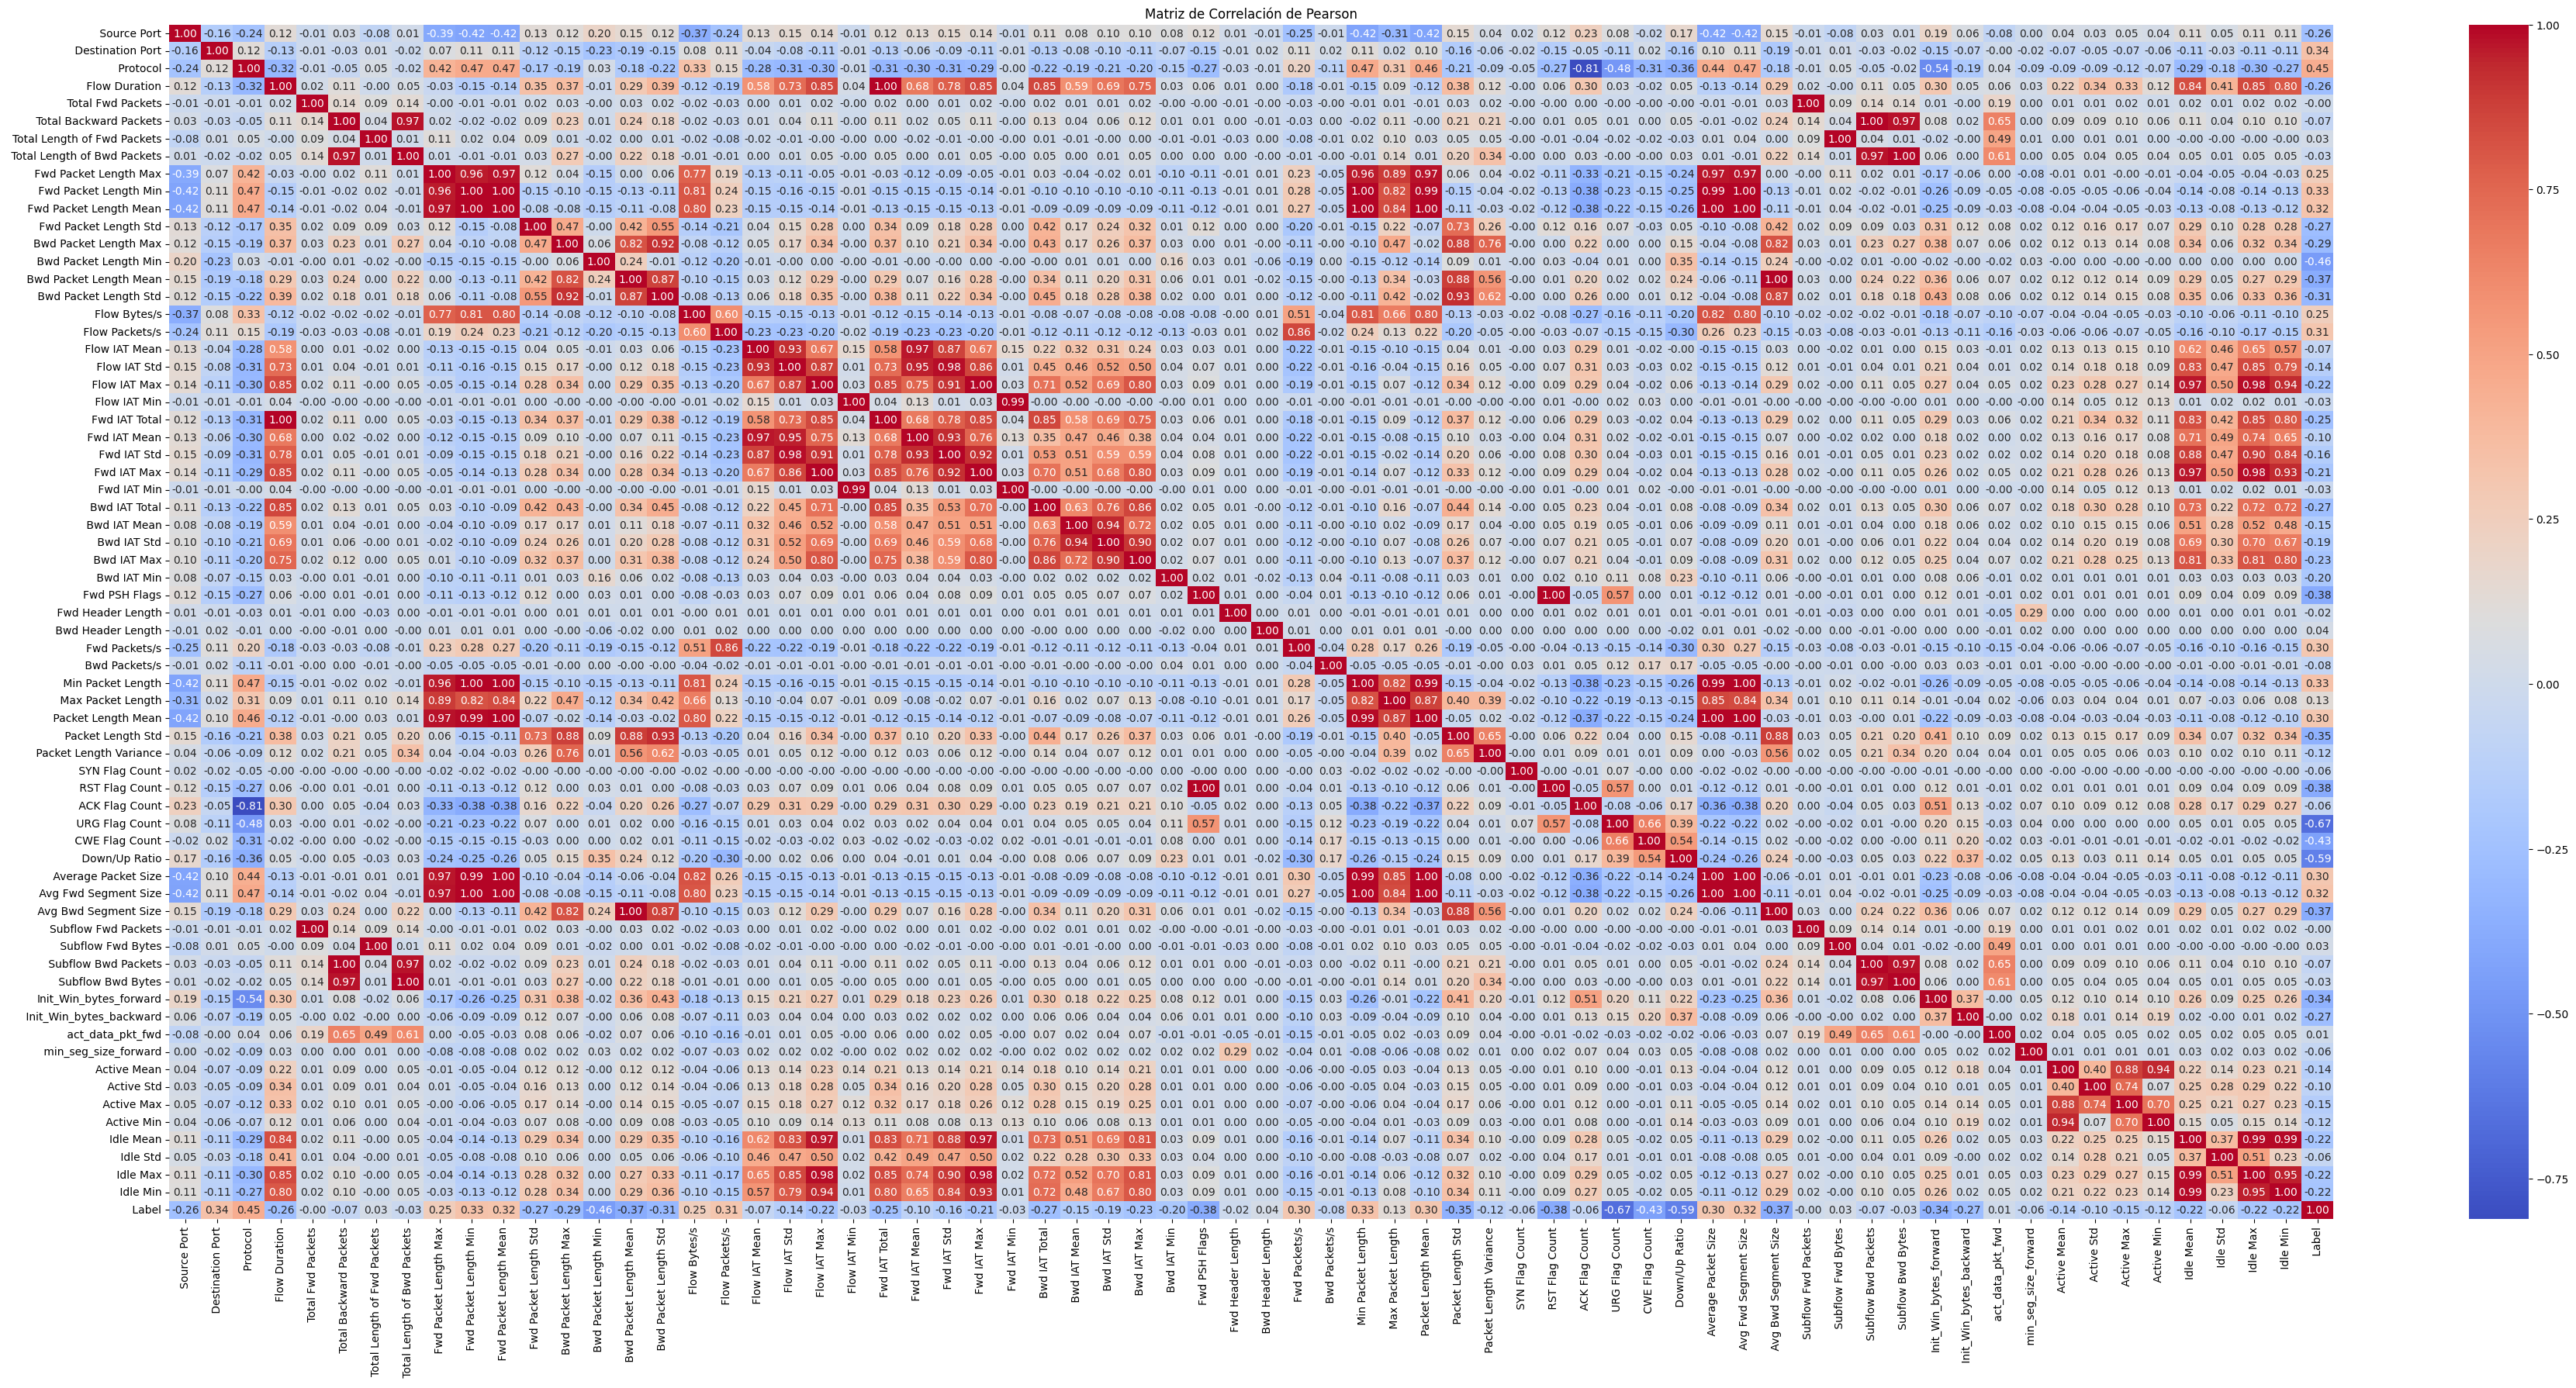

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el archivo Parquet
file_path = r'C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\Parquet\\dataset_preprocessed.parquet'
df = pd.read_parquet(file_path)

# Calcular la matriz de correlación utilizando el coeficiente de correlación de Pearson
correlation_matrix = df.corr(method='pearson')

# Visualizar la matriz de correlación usando un mapa de calor
plt.figure(figsize=(45, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Pearson')
plt.show()

2. Algoritmo Feature Importance, método de selección de características basado en modelos

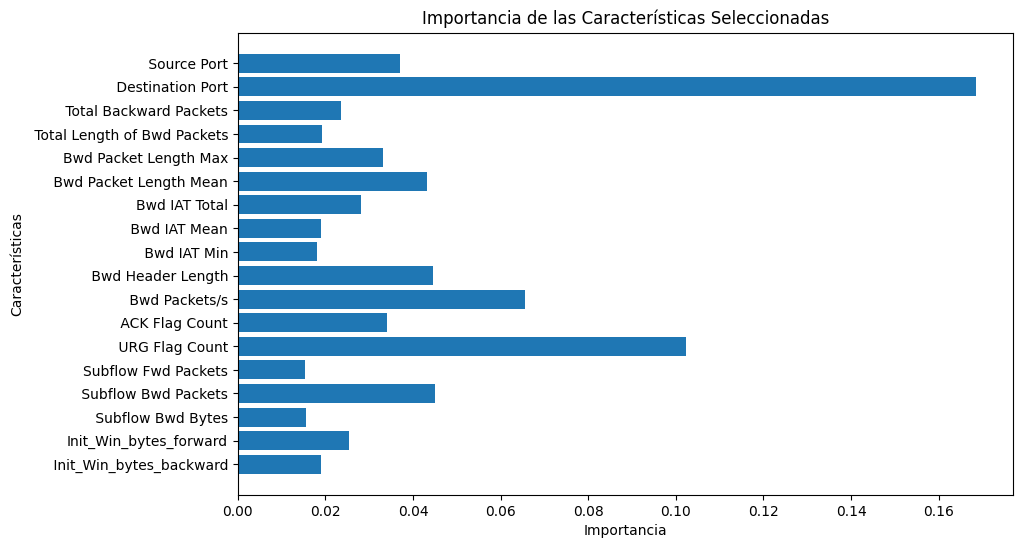

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

def plot_feature_importance(file_path):
    # Cargar conjunto de datos preprocesado
    df = pd.read_parquet(file_path)

    # Dividir en características y etiquetas
    X = df.drop(' Label', axis=1)
    y = df[' Label']

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar modelo inicial
    rf_initial = RandomForestClassifier(random_state=42)
    rf_initial.fit(X_train, y_train)

    # Obtener la importancia de las características
    importances = rf_initial.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Seleccionar características con importancia mayor o igual que la media
    mean_importance = feature_importances['importance'].mean()
    selected_importances = feature_importances[feature_importances['importance'] >= mean_importance]
    selected_importances = selected_importances.sort_values(by='importance', ascending=False)

    # Guardar las características seleccionadas en un archivo CSV
    selected_importances.to_csv('selected_features.csv', index=False)

    # Graficar la importancia de las características seleccionadas
    plt.figure(figsize=(10, 6))
    plt.barh(selected_importances['feature'], selected_importances['importance'])
    plt.xlabel('Importancia')
    plt.ylabel('Características')
    plt.title('Importancia de las Características Seleccionadas')
    plt.gca().invert_yaxis()
    plt.show()

# Ruta del archivo
file_path = 'C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\Parquet\\dataset_preprocessed.parquet'
plot_feature_importance(file_path)

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

def train_with_selected_features(file_path):
    # Cargar conjunto de datos preprocesado
    df = pd.read_parquet(file_path)

    # Dividir en características y etiquetas
    X = df.drop(' Label', axis=1)
    y = df[' Label']

    # Dividir en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Entrenar modelo inicial
    rf_initial = RandomForestClassifier(random_state=42)
    rf_initial.fit(X_train, y_train)

    # Obtener la importancia de las características
    importances = rf_initial.feature_importances_
    feature_names = X_train.columns
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

    # Seleccionar características con importancia mayor o igual que la media
    mean_importance = feature_importances['importance'].mean()
    selected_features = feature_importances[feature_importances['importance'] >= mean_importance]['feature']

    # Filtrar el conjunto de datos para incluir solo las características seleccionadas
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Entrenar un nuevo modelo con las características seleccionadas
    rf_final = RandomForestClassifier(random_state=42)
    rf_final.fit(X_train_selected, y_train)

    # Predecir y evaluar el modelo
    y_pred = rf_final.predict(X_test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    # Imprimir los resultados
    print(f'Accuracy: {accuracy}')
    print('Classification Report:')
    print(report)

# Ruta del archivo
file_path = 'C:\\TFG_Javier_Jimenez\\DataSet_CIC-DDoS2019\\Parquet\\dataset_preprocessed.parquet'
train_with_selected_features(file_path)

Accuracy: 0.9999479501014973
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     17298
           1       1.00      1.00      1.00    155613

    accuracy                           1.00    172911
   macro avg       1.00      1.00      1.00    172911
weighted avg       1.00      1.00      1.00    172911

